# Table of Contents:
* [0 -Importing Libraries](#0)
* [1 - Read in data](#1)
* [2 - SIR](#2)
* [3 - Descriptive Facts](#3)
* [4 - Prepare the dataset (change in turnout)](#4)
* [5 - Regressions](#5)

# 0) Imports <a class="anchor" id="0"></a>

In [1]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ast  

# 1) Read in data <a class="anchor" id="1"></a>

In [2]:
# Initialize an empty list to store the data
data = []

# Define keys based on the dataset format
keys = ['#*', '#@', '#t', '#c', '#index', '#%', '#!']

# Open the file and read the contents
with open('small.txt', 'r', encoding='ISO-8859-1') as file:
    current_paper = {}
    for line in file:
        line = line.strip()
        if line.startswith('#*'):
            # New paper starts; save the previous one if it exists
            if current_paper:
                data.append(current_paper)
                current_paper = {}
            current_paper['Title'] = line[2:].strip()
        elif line.startswith('#@'):
            current_paper['Authors'] = line[2:].strip()
        elif line.startswith('#t'):
            current_paper['Year'] = line[2:].strip()
        elif line.startswith('#c'):
            current_paper['Venue'] = line[2:].strip()
        elif line.startswith('#index'):
            current_paper['Index ID'] = line[6:].strip()
        elif line.startswith('#%'):
            if 'References' not in current_paper:
                current_paper['References'] = []
            current_paper['References'].append(line[2:].strip())
        elif line.startswith('#!'):
            current_paper['Abstract'] = line[2:].strip()
        elif line.isdigit() and current_paper:  # Handle end of current paper
            data.append(current_paper)
            current_paper = {}
    # Add the last paper
    if current_paper:
        data.append(current_paper)

# Convert list of dicts to DataFrame
df = pd.DataFrame(data)

# Replacing missing keys with None which becomes NaN in DataFrame
for key in ['Title', 'Authors', 'Year', 'Venue', 'Index ID', 'References', 'Abstract']:
    if key not in df.columns:
        df[key] = None

In [3]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
# Apply the function to the DataFrame column
df['References'] = df['References'].apply(
    lambda x: [int(i) for i in x] if isinstance(x, list) else x
)

Last Cited Year (for SIR)

In [4]:
# Creating a dictionary from the DataFrame assuming 'Index ID' and 'Year' are columns in your DataFrame
year_dict = df.set_index('Index ID')['Year'].to_dict()

def get_last_cited_year(ref_ids):
    if not isinstance(ref_ids, list):
        return np.nan
    # Filter and collect years where reference IDs exist in year_dict
    years = [year_dict.get(int(ref_id)) for ref_id in ref_ids if int(ref_id) in year_dict]
    return max(years) if years else np.nan

# Apply the function to the 'References' column to compute the 'Last Cited Year'
df['Last Cited Year'] = df['References'].apply(get_last_cited_year)

In [5]:
df.iloc[:100].to_csv('small.csv', index=False)

# 2) SIR model <a class="anchor" id="2"></a>

To estimate the initial conditions and parameters (such as \(S_0\), \(I_0\), \(R_0\), \(\beta\), and \(\gamma\)) from your dataset for modeling the spread of ideas using the SIR model, you should analyze the data you have available, especially focusing on how widely and quickly ideas (represented by citations) are adopted and discarded. Here’s how you could approach this:

### Estimating Initial Conditions and Parameters:

1. **Estimate \(I_0\) (Initial Infected):**
   - Identify seminal papers or early influential works. For example, papers that are among the first to cite a particular idea or methodology.
   - \(I_0\) could be the count of these papers or authors in the earliest time period you are examining.

2. **Estimate \(S_0\) (Initial Susceptible):**
   - Consider the total potential audience for the idea. This might be approximated by the number of authors in the field or related fields during the time period of your analysis.
   - Subtract \(I_0\) from this total to get \(S_0\).

3. **Estimate \(R_0\) (Initial Recovered):**
   - Initially, \(R_0\) could be zero unless you have data from before the start of your study period indicating researchers who have ceased to contribute to the field.

4. **Estimate \(\beta\) (Transmission Rate):**
   - Analyze the average number of times the seminal papers are cited by new papers per year. This rate could provide a proxy for \(\beta\), indicating the likelihood of a susceptible researcher adopting the idea after encountering it.

5. **Estimate \(\gamma\) (Recovery Rate):**
   - Determine the typical duration over which researchers continue to publish on the idea before moving on to other topics. For instance, if researchers typically stop citing the original papers after about 5 years, then \(\gamma\) could be approximated as 1/5 per year.

### Putting It into Code:
Now let's assume you have some values based on the above estimations and how you might put them into code using a hypothetical scenario.

In this setup:
- The `total_authors` might be estimated from your data or relevant literature.
- `initial_influential_papers` is based on an examination of the earliest influential works (you would need to analyze the data to find these).
- `beta` and `gamma` are hypothetical and should be refined with real data or expert input from the specific academic field.

This code provides a basic simulation; the parameters and initial conditions would need to be adapted based on deeper data analysis and domain-specific knowledge about the spread of ideas in the field you are studying.

In [6]:
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

In [7]:
# Calculate total authors
df['Authors'] = df['Authors'].fillna('')  # Fill empty strings where there are no authors
unique_authors = set()
df['Authors'].apply(lambda x: unique_authors.update(x.split(',')) if x else None)
total_authors = len(unique_authors) - 1 if '' in unique_authors else len(unique_authors)

# Identify influential papers
df['Is Influential'] = df['References'].apply(lambda x: len(x) if isinstance(x, list) else 0)
initial_influential_papers = df[df['Is Influential'] > 0]['Year'].min()  # Find the earliest year of influential papers
influential_count = df[(df['Year'] == initial_influential_papers) & (df['Is Influential'] > 0)].shape[0]

In [8]:
# Set initial conditions for the SIR model
S0 = total_authors - influential_count  # Susceptible researchers
I0 = influential_count  # Infected/influential researchers
R0 = 0  # Initially no recovered

Estimate Beta

In [9]:
# Here, we'll create a simplified version assuming the 'References' column lists IDs of papers this paper cites:
citation_counts = df['References'].apply(lambda x: len(x) if isinstance(x, list) else 0)
average_citations_per_year = citation_counts.mean() / (2022 - df['Year'].min())

# Adjust for number of authors (assuming split by commas, and ignoring papers with no authors listed)
df['Author Count'] = df['Authors'].apply(lambda x: len(x.split(',')) if x else 0)
average_authors_per_paper = df['Author Count'].mean()

# Calculate beta as the average citation rate per author per year
beta = average_citations_per_year / average_authors_per_paper

Estimate gamma

In [10]:
# Calculate lifespan of citations
df['Citation Lifespan'] = df['Last Cited Year'] - df['Year']
average_citation_lifespan = df['Citation Lifespan'].mean()

# Calculate gamma as the reciprocal of the average lifespan
gamma = 1 / average_citation_lifespan

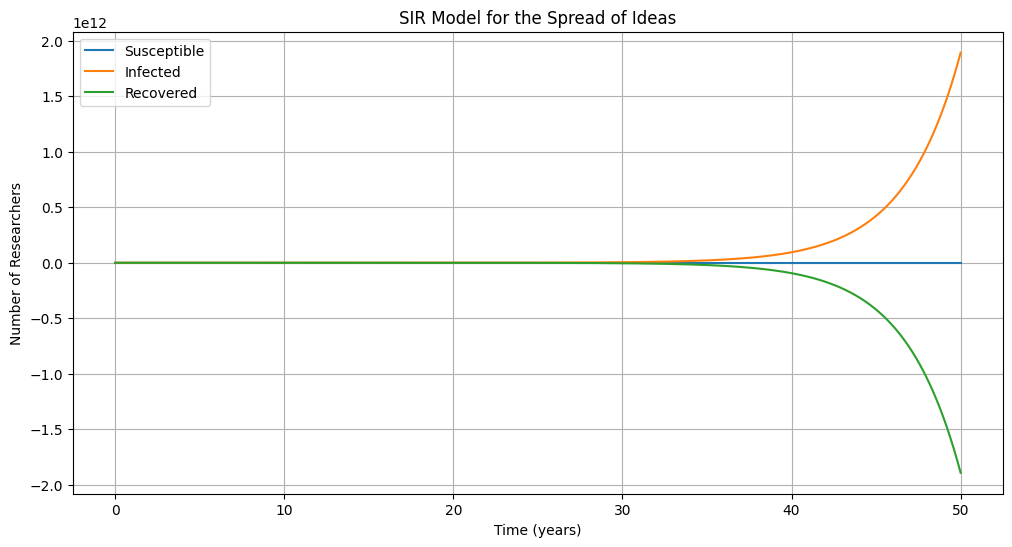

In [11]:
# Initial conditions vector
y0 = [S0, I0, R0]

# Time points
t = np.linspace(0, 50, 1000)  # Simulate over 50 years

# Integrate the SIR equations over the time grid t
solution = odeint(sir_model, y0, t, args=(beta, gamma))
solution = np.array(solution)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t, solution[:, 0], label='Susceptible')
plt.plot(t, solution[:, 1], label='Infected')
plt.plot(t, solution[:, 2], label='Recovered')
plt.title('SIR Model for the Spread of Ideas')
plt.xlabel('Time (years)')
plt.ylabel('Number of Researchers')
plt.legend()
plt.grid(True)
plt.show()

# MSE

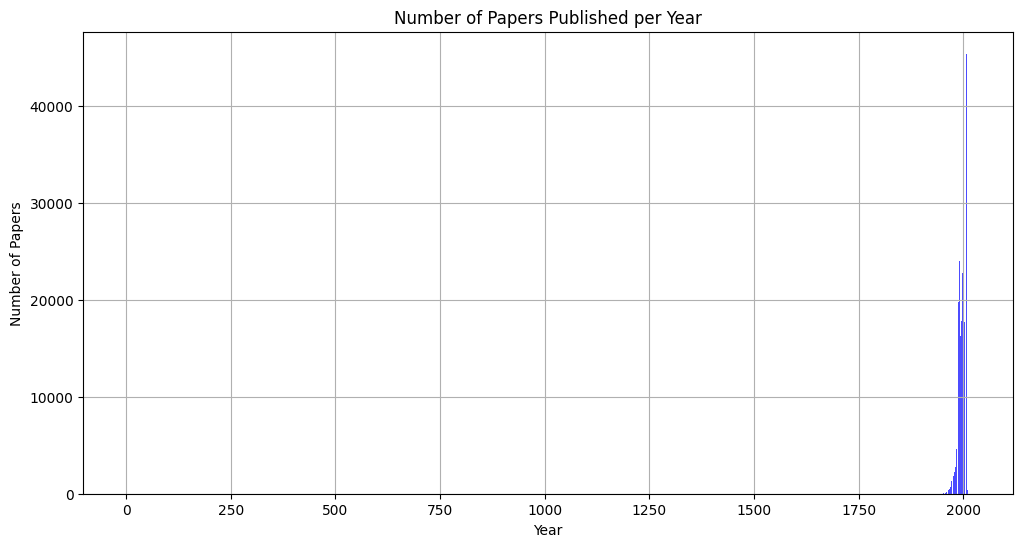

Mean Squared Error: 1.2114796765160098e+23


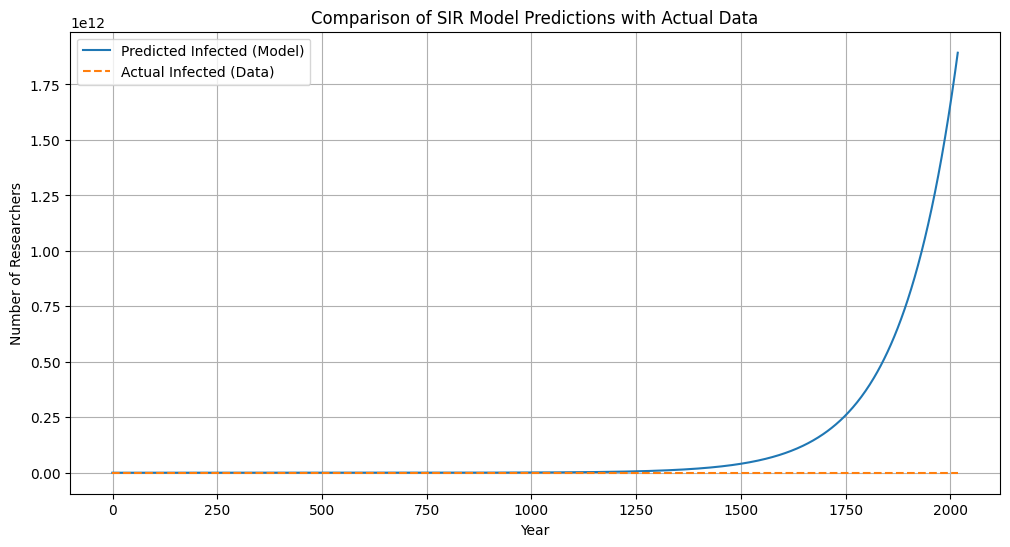

In [12]:
# Step 1: Count papers per year as a proxy for the spread of ideas.
papers_per_year = df['Year'].value_counts().sort_index()

# Step 2: Plot this data to visualize the trend
plt.figure(figsize=(12, 6))
plt.bar(papers_per_year.index, papers_per_year.values, color='blue', alpha=0.7)
plt.title('Number of Papers Published per Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.grid(True)
plt.show()

# Convert papers_per_year to a numpy array matching the time steps of the SIR model (if necessary)
# This requires aligning the time steps from the model with the actual data.
# Assuming the model's timesteps start from the minimum year in the dataset and end at the maximum.

t_model = np.linspace(df['Year'].min(), df['Year'].max(), num=1000)  # Adjusted time vector for the model
actual_data = np.interp(t_model, papers_per_year.index, papers_per_year.values)  # Interpolating actual data to model's timesteps

# Note: Ensure 'solution' contains the SIR model output
predicted_infected = solution[:, 1]  # Extract the 'Infected' from SIR model output

# MSE calculation function
def calculate_mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

# Calculate MSE
mse = calculate_mse(actual_data, predicted_infected)
print("Mean Squared Error:", mse)

# Plot both actual and predicted for comparison
plt.figure(figsize=(12, 6))
plt.plot(t_model, predicted_infected, label='Predicted Infected (Model)')
plt.plot(t_model, actual_data, label='Actual Infected (Data)', linestyle='--')
plt.title('Comparison of SIR Model Predictions with Actual Data')
plt.xlabel('Year')
plt.ylabel('Number of Researchers')
plt.legend()
plt.grid(True)
plt.show()